# Bank Churners

***The objective of this analysis is to build a classification model that predicts customer attrition, in order to personalize the retention campaigns to the customers most likely to leave, optmizing the company's budget***

### What is Attrition ?
The  process of reudcing something's strength or effectiveness through sustained attack or pressure. Attrition occurs when the workforce dwindles at a company as people leave and are replaced Attrition is often called a hiring freeze and is seen as **a less disruptive way to trim the workfoce and reduce payroll than layoffs**

**Since we are trying to predict attrition, the best model will be one that covers the most attrited customers from our test dataset (we wont care mucn for the false positives)**

In [90]:
# Importing all the libraries necessary

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import sklearn 
import scipy.stats
from IPython.display import display

from matplotlib import figure
from IPython.display import Image


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, make_scorer, silhouette_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold


from scipy.stats import chi2

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Exploring The Data

df_explore = pd.read_csv('BankChurners.csv')
df_explore.info

<bound method DataFrame.info of        CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income

In [83]:
# Printing out all the columns

print('-------------Columns-------------')
print(list(df_explore.columns))

-------------Columns-------------
['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


In [84]:
# Check if any column has null values.

df_explore.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [96]:
#Check for duplicate
print('---Check for duplicate---')
print(df_explore[df_explore.duplicated(keep=False)])
print('\n')

print('---Check for duplicate IDS---')
print(df_explore.duplicated(subset=['CLIENTNUM']).unique())
print('\n')

#check for Unknown Values
print('---Check for Unknowns---')
print(df_explore[df_explore == 'Unknown'].count())
print('\n')

#Check for Zero Values
print('---Check for 0 Values---')
df_explore[df_explore == 0].count()


---Check for duplicate---
Empty DataFrame
Columns: [CLIENTNUM, Attrition_Flag, Customer_Age, Gender, Dependent_count, Education_Level, Marital_Status, Income_Category, Card_Category, Months_on_book, Total_Relationship_Count, Months_Inactive_12_mon, Contacts_Count_12_mon, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2]
Index: []

[0 rows x 23 columns]


---Check for duplicate IDS---
[False]


---Check for Unknowns---
CLIENTNUM                                                                                                                                0
Attrition_Flag                                                            

CLIENTNUM                                                                                                                                0
Attrition_Flag                                                                                                                           0
Customer_Age                                                                                                                             0
Gender                                                                                                                                   0
Dependent_count                                                                                                                        904
Education_Level                                                                                                                          0
Marital_Status                                                                                                                           0
Income_Category            

### We have unknown values in

- #### Education_Level
- #### Marital_Status
- #### Income_Category
### We can later map them or filter them before building the models

In [87]:
# Counting the Attrition Flags

aggregate_data = df_explore.groupby(['Attrition_Flag'])['CLIENTNUM'].count().to_frame().reset_index()
aggregate_data

,Attrition_Flag,CLIENTNUM
0,Attrited Customer,1627
1,Existing Customer,8500


# EDA

In [136]:
# A pie plot to better represent the data

labels = df_explore.Attrition_Flag
values = df_explore.CLIENTNUM

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2])])
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.90,
    xanchor="left",
    x=0.20
))

##### We have some categorical data, lets see if the groups are statistically significant or insignificant

## Gender

In [98]:
# Gender

cross_tab = pd.crosstab(index=df_explore['Gender'],
                        columns=df_explore['Attrition_Flag'])


cross_tab_prop = pd.crosstab(index=df_explore['Gender'],
                        columns=df_explore['Attrition_Flag'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reset_index()
cross_tab_prop

Attrition_Flag,Gender,Attrited Customer,Existing Customer
0,F,0.173572,0.826428
1,M,0.146152,0.853848


In [99]:
### Check if the difference between the two groups is statistically significant
 
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(cross_tab)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     13.866
p-value:            0.00019636
degrees of freedom: 1
expected frequencies:
 [[ 860.81425891 4497.18574109]
 [ 766.18574109 4002.81425891]]


#### The difference here is significant as p-value < 0.05

### Income

In [100]:
cross_tab = pd.crosstab(index=df_explore['Income_Category'],
                        columns=df_explore['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index=df_explore['Income_Category'],
                        columns=df_explore['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,Attrited Customer,Existing Customer
Income_Category,,
$120K +,0.173315,0.826685
$40K - $60K,0.151397,0.848603
$60K - $80K,0.134807,0.865193
$80K - $120K,0.157655,0.842345
Less than $40K,0.171862,0.828138
Unknown,0.168165,0.831835


In [101]:
### Check if the difference between the income groups is statistically significant


chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(cross_tab)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     12.832
p-value:            0.025002
degrees of freedom: 5
expected frequencies:
 [[ 116.79954577  610.20045423]
 [ 287.5807248  1502.4192752 ]
 [ 225.24479115 1176.75520885]
 [ 246.61252098 1288.38747902]
 [ 572.10891676 2988.89108324]
 [ 178.65350054  933.34649946]]


#### Here the p-value is 0.025002 which is less than (<) 0.05. Hence we can say that the difference between the groups here is significant.

### Marital_Status

In [102]:
cross_tab = pd.crosstab(index=df_explore['Marital_Status'],
                        columns=df_explore['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index=df_explore['Marital_Status'],
                        columns=df_explore['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,Attrited Customer,Existing Customer
Marital_Status,,
Divorced,0.161765,0.838235
Married,0.151269,0.848731
Single,0.169414,0.830586
Unknown,0.172230,0.827770


In [103]:
### Check if the difference between the marital status groups is statistically significant

chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(cross_tab)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     6.0561
p-value:            0.10891
degrees of freedom: 3
expected frequencies:
 [[ 120.17339785  627.82660215]
 [ 753.01165202 3933.98834798]
 [ 633.48089266 3309.51910734]
 [ 120.33405747  628.66594253]]


#### The difference is not significant

### Card_Category

In [104]:
cross_tab = pd.crosstab(index=df_explore['Card_Category'],
                        columns=df_explore['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index=df_explore['Card_Category'],
                        columns=df_explore['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,Attrited Customer,Existing Customer
Card_Category,,
Blue,0.160979,0.839021
Gold,0.181034,0.818966
Platinum,0.250000,0.750000
Silver,0.147748,0.852252


In [105]:
### Check if the difference between the card_category groups is statistically significant

chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(cross_tab)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     2.2342
p-value:            0.52524
degrees of freedom: 3
expected frequencies:
 [[1.51598420e+03 7.92001580e+03]
 [1.86365162e+01 9.73634838e+01]
 [3.21319246e+00 1.67868075e+01]
 [8.91660906e+01 4.65833909e+02]]


#### The difference is not significant

### Education level

In [106]:
cross_tab = pd.crosstab(index=df_explore['Education_Level'],
                        columns=df_explore['Attrition_Flag'])

cross_tab_prop = pd.crosstab(index=df_explore['Education_Level'],
                        columns=df_explore['Attrition_Flag'],
                             normalize="index")
cross_tab_prop

Attrition_Flag,Attrited Customer,Existing Customer
Education_Level,,
College,0.152024,0.847976
Doctorate,0.210643,0.789357
Graduate,0.155691,0.844309
High School,0.152012,0.847988
Post-Graduate,0.178295,0.821705
Uneducated,0.159381,0.840619
Unknown,0.168532,0.831468


In [107]:
### Check if the difference between the education_level groups is statistically significant

chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(cross_tab)
 
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)

chi2 statistic:     12.511
p-value:            0.051489
degrees of freedom: 6
expected frequencies:
 [[ 162.74819789  850.25180211]
 [  72.45748988  378.54251012]
 [ 502.54330009 2625.45669991]
 [ 323.40782068 1689.59217932]
 [  82.90036536  433.09963464]
 [ 238.90085909 1248.09914091]
 [ 244.04196702 1274.95803298]]


#### The difference is not significant

### Numeric Values

<Axes: xlabel='Attrition_Flag', ylabel='Customer_Age'>

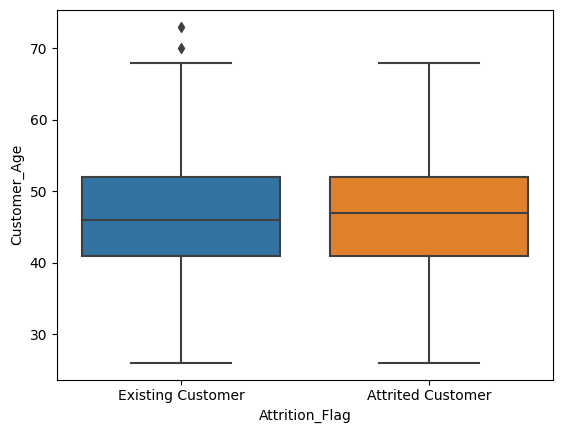

In [119]:
sns.boxplot(x='Attrition_Flag', y='Customer_Age', data=df_explore)


#### The difference is not significant

<Axes: xlabel='Attrition_Flag', ylabel='Dependent_count'>

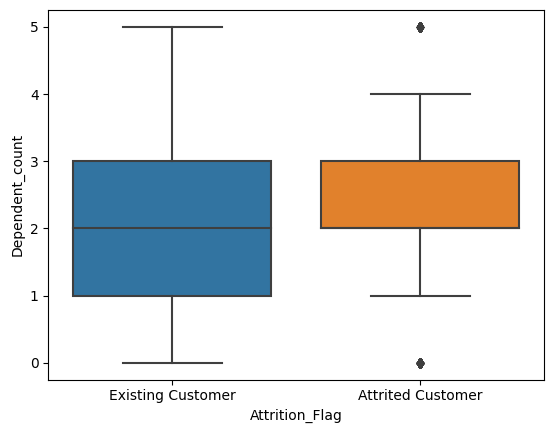

In [120]:
sns.boxplot(x='Attrition_Flag', y='Dependent_count', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Months_on_book'>

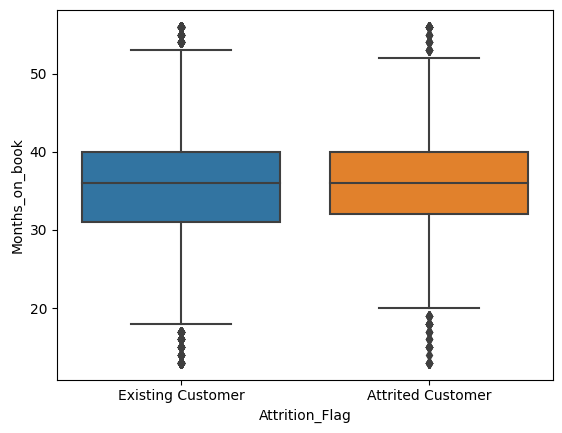

In [121]:
sns.boxplot(x='Attrition_Flag', y='Months_on_book', data=df_explore)


#### The difference is not significant

<Axes: xlabel='Attrition_Flag', ylabel='Total_Relationship_Count'>

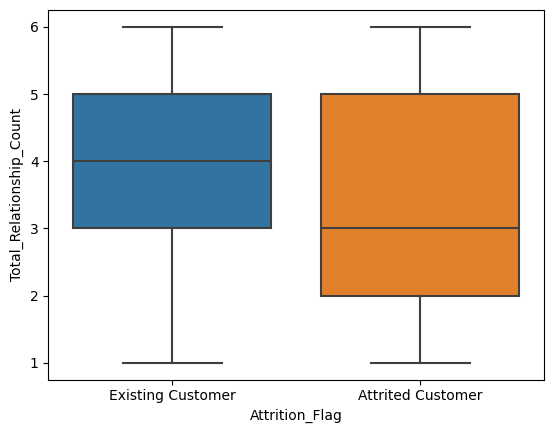

In [122]:
sns.boxplot(x='Attrition_Flag', y='Total_Relationship_Count', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Months_Inactive_12_mon'>

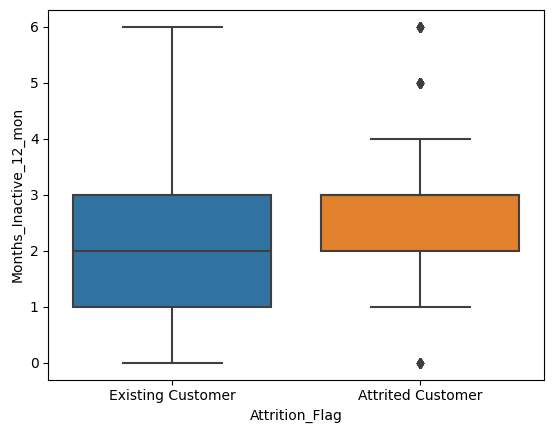

In [123]:
sns.boxplot(x='Attrition_Flag', y='Months_Inactive_12_mon', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Contacts_Count_12_mon'>

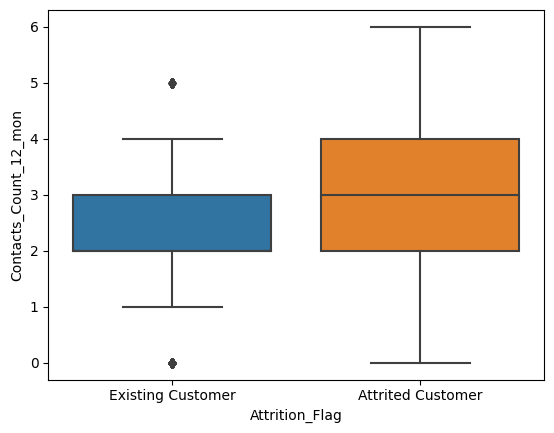

In [124]:
sns.boxplot(x='Attrition_Flag', y='Contacts_Count_12_mon', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Credit_Limit'>

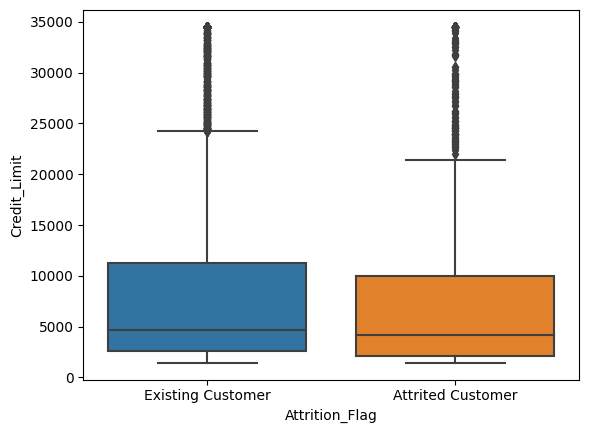

In [125]:
sns.boxplot(x='Attrition_Flag', y='Credit_Limit', data=df_explore)


#### The difference here is very small

<Axes: xlabel='Attrition_Flag', ylabel='Total_Revolving_Bal'>

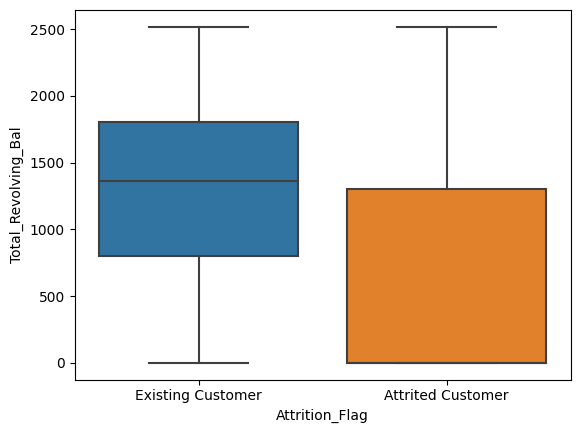

In [126]:
sns.boxplot(x='Attrition_Flag', y='Total_Revolving_Bal', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Avg_Open_To_Buy'>

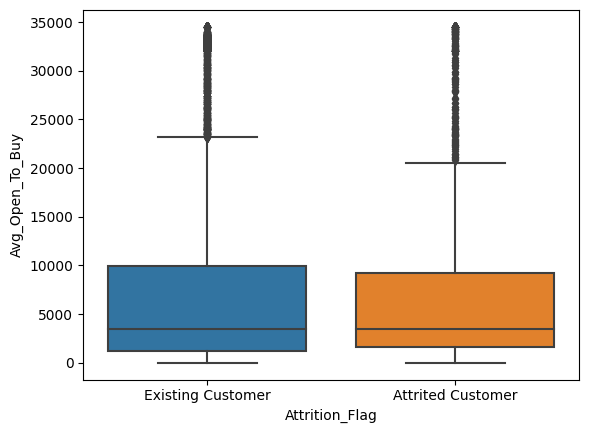

In [127]:
sns.boxplot(x='Attrition_Flag', y='Avg_Open_To_Buy', data=df_explore)


#### The difference is not significant

<Axes: xlabel='Attrition_Flag', ylabel='Total_Amt_Chng_Q4_Q1'>

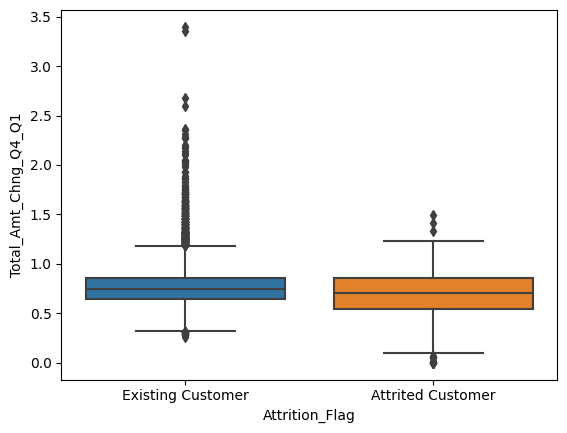

In [128]:
sns.boxplot(x='Attrition_Flag', y='Total_Amt_Chng_Q4_Q1', data=df_explore)


#### The difference is slightly different

<Axes: xlabel='Attrition_Flag', ylabel='Total_Trans_Amt'>

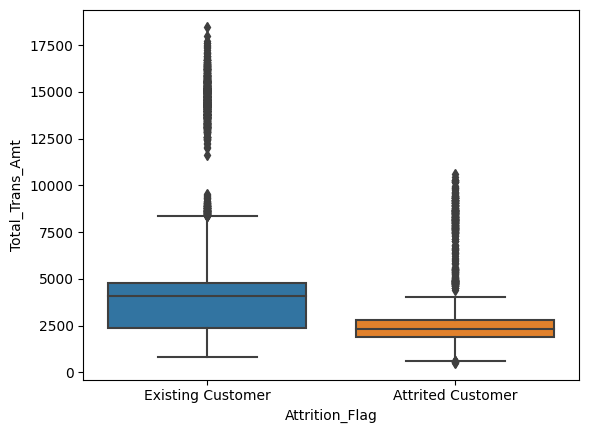

In [129]:
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Total_Trans_Ct'>

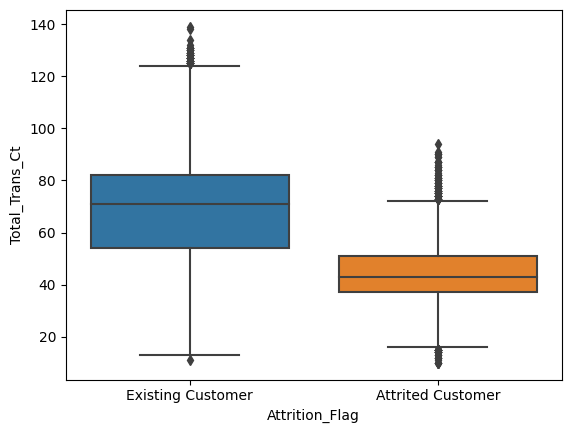

In [130]:
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Ct', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

<Axes: xlabel='Attrition_Flag', ylabel='Total_Ct_Chng_Q4_Q1'>

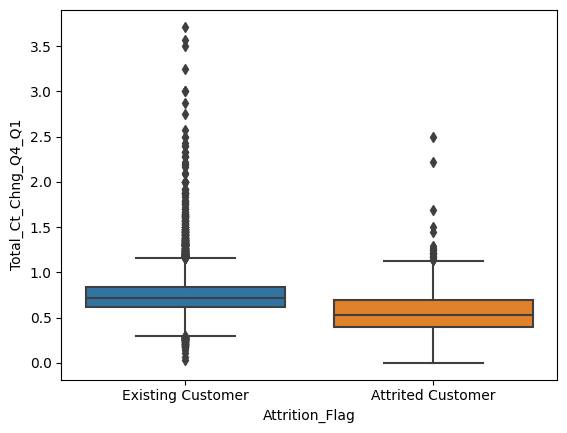

In [131]:
sns.boxplot(x='Attrition_Flag', y='Total_Ct_Chng_Q4_Q1', data=df_explore)


#### The difference is slightly different

<Axes: xlabel='Attrition_Flag', ylabel='Avg_Utilization_Ratio'>

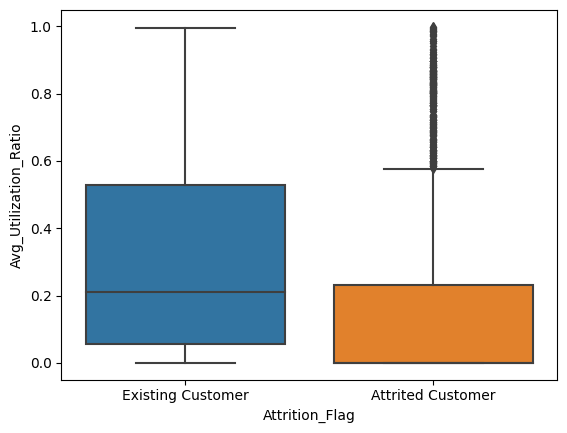

In [132]:
sns.boxplot(x='Attrition_Flag', y='Avg_Utilization_Ratio', data=df_explore)


#### The difference is significant, hence it can be used in the model as predictor

## Data Preprocessing and cleaning

In [133]:
df_explore.head(20)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


#### As we see from above, there are two columns that represent classification for the Attrition flag using Naive Baues Classifier. We cannot have this in our data set as this will skew the results entrirely and would lead to a 100% accuracy score which would not be a true representation for the accuracy of the model we apply and thus the classification would become invalid.

In [94]:
# Listing all the columns in the dataset and lookinng some info about the data
print('\n')
print('-------------Dataset-------------')
df_explore.head(10)



-------------Dataset-------------


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


In [4]:
# Dropping the Naive_Bayes_Classifier columns (There are 2 in the dataset)

df = df_explore.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df.columns 

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

## Converting Categorical Data into Numerical Data

#### We need to convert categorical data into numerical data as this would massively help in making sure that all data is accounted for its relation to the attriotion flag and helps us fully understand the relationship with the attrtition.

In [9]:
cat_to_num = [
    "Attrition_Flag",
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category"
]

cat_mapping = dict()
lenc = LabelEncoder()
for c in cat_to_num:
    cat_mapping[c] = lenc.fit_transform(df.loc[:, c])
cat_df = pd.DataFrame(cat_mapping)

In [10]:
numerical_features = [f for f in df.columns if f not in cat_to_num]
df_numerical = df.loc[:, numerical_features]

In [11]:
df_main = pd.concat([cat_df, df_numerical], axis=1)
display(df_main.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Gender                    10127 non-null  int64  
 2   Education_Level           10127 non-null  int64  
 3   Marital_Status            10127 non-null  int64  
 4   Income_Category           10127 non-null  int64  
 5   Card_Category             10127 non-null  int64  
 6   CLIENTNUM                 10127 non-null  int64  
 7   Customer_Age              10127 non-null  int64  
 8   Dependent_count           10127 non-null  int64  
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

None

In [12]:
df_main.head(20)

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,1,3,1,2,0,768805383,45,3,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,0,2,2,4,0,818770008,49,5,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,1,2,1,3,0,713982108,51,3,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,0,3,3,4,0,769911858,40,4,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,1,5,1,2,0,709106358,40,3,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,1,1,2,1,1,0,713061558,44,2,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,1,1,6,1,0,1,810347208,51,4,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,1,1,3,3,2,3,818906208,32,0,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,1,1,5,2,2,0,710930508,37,3,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,1,1,2,2,3,0,719661558,48,2,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


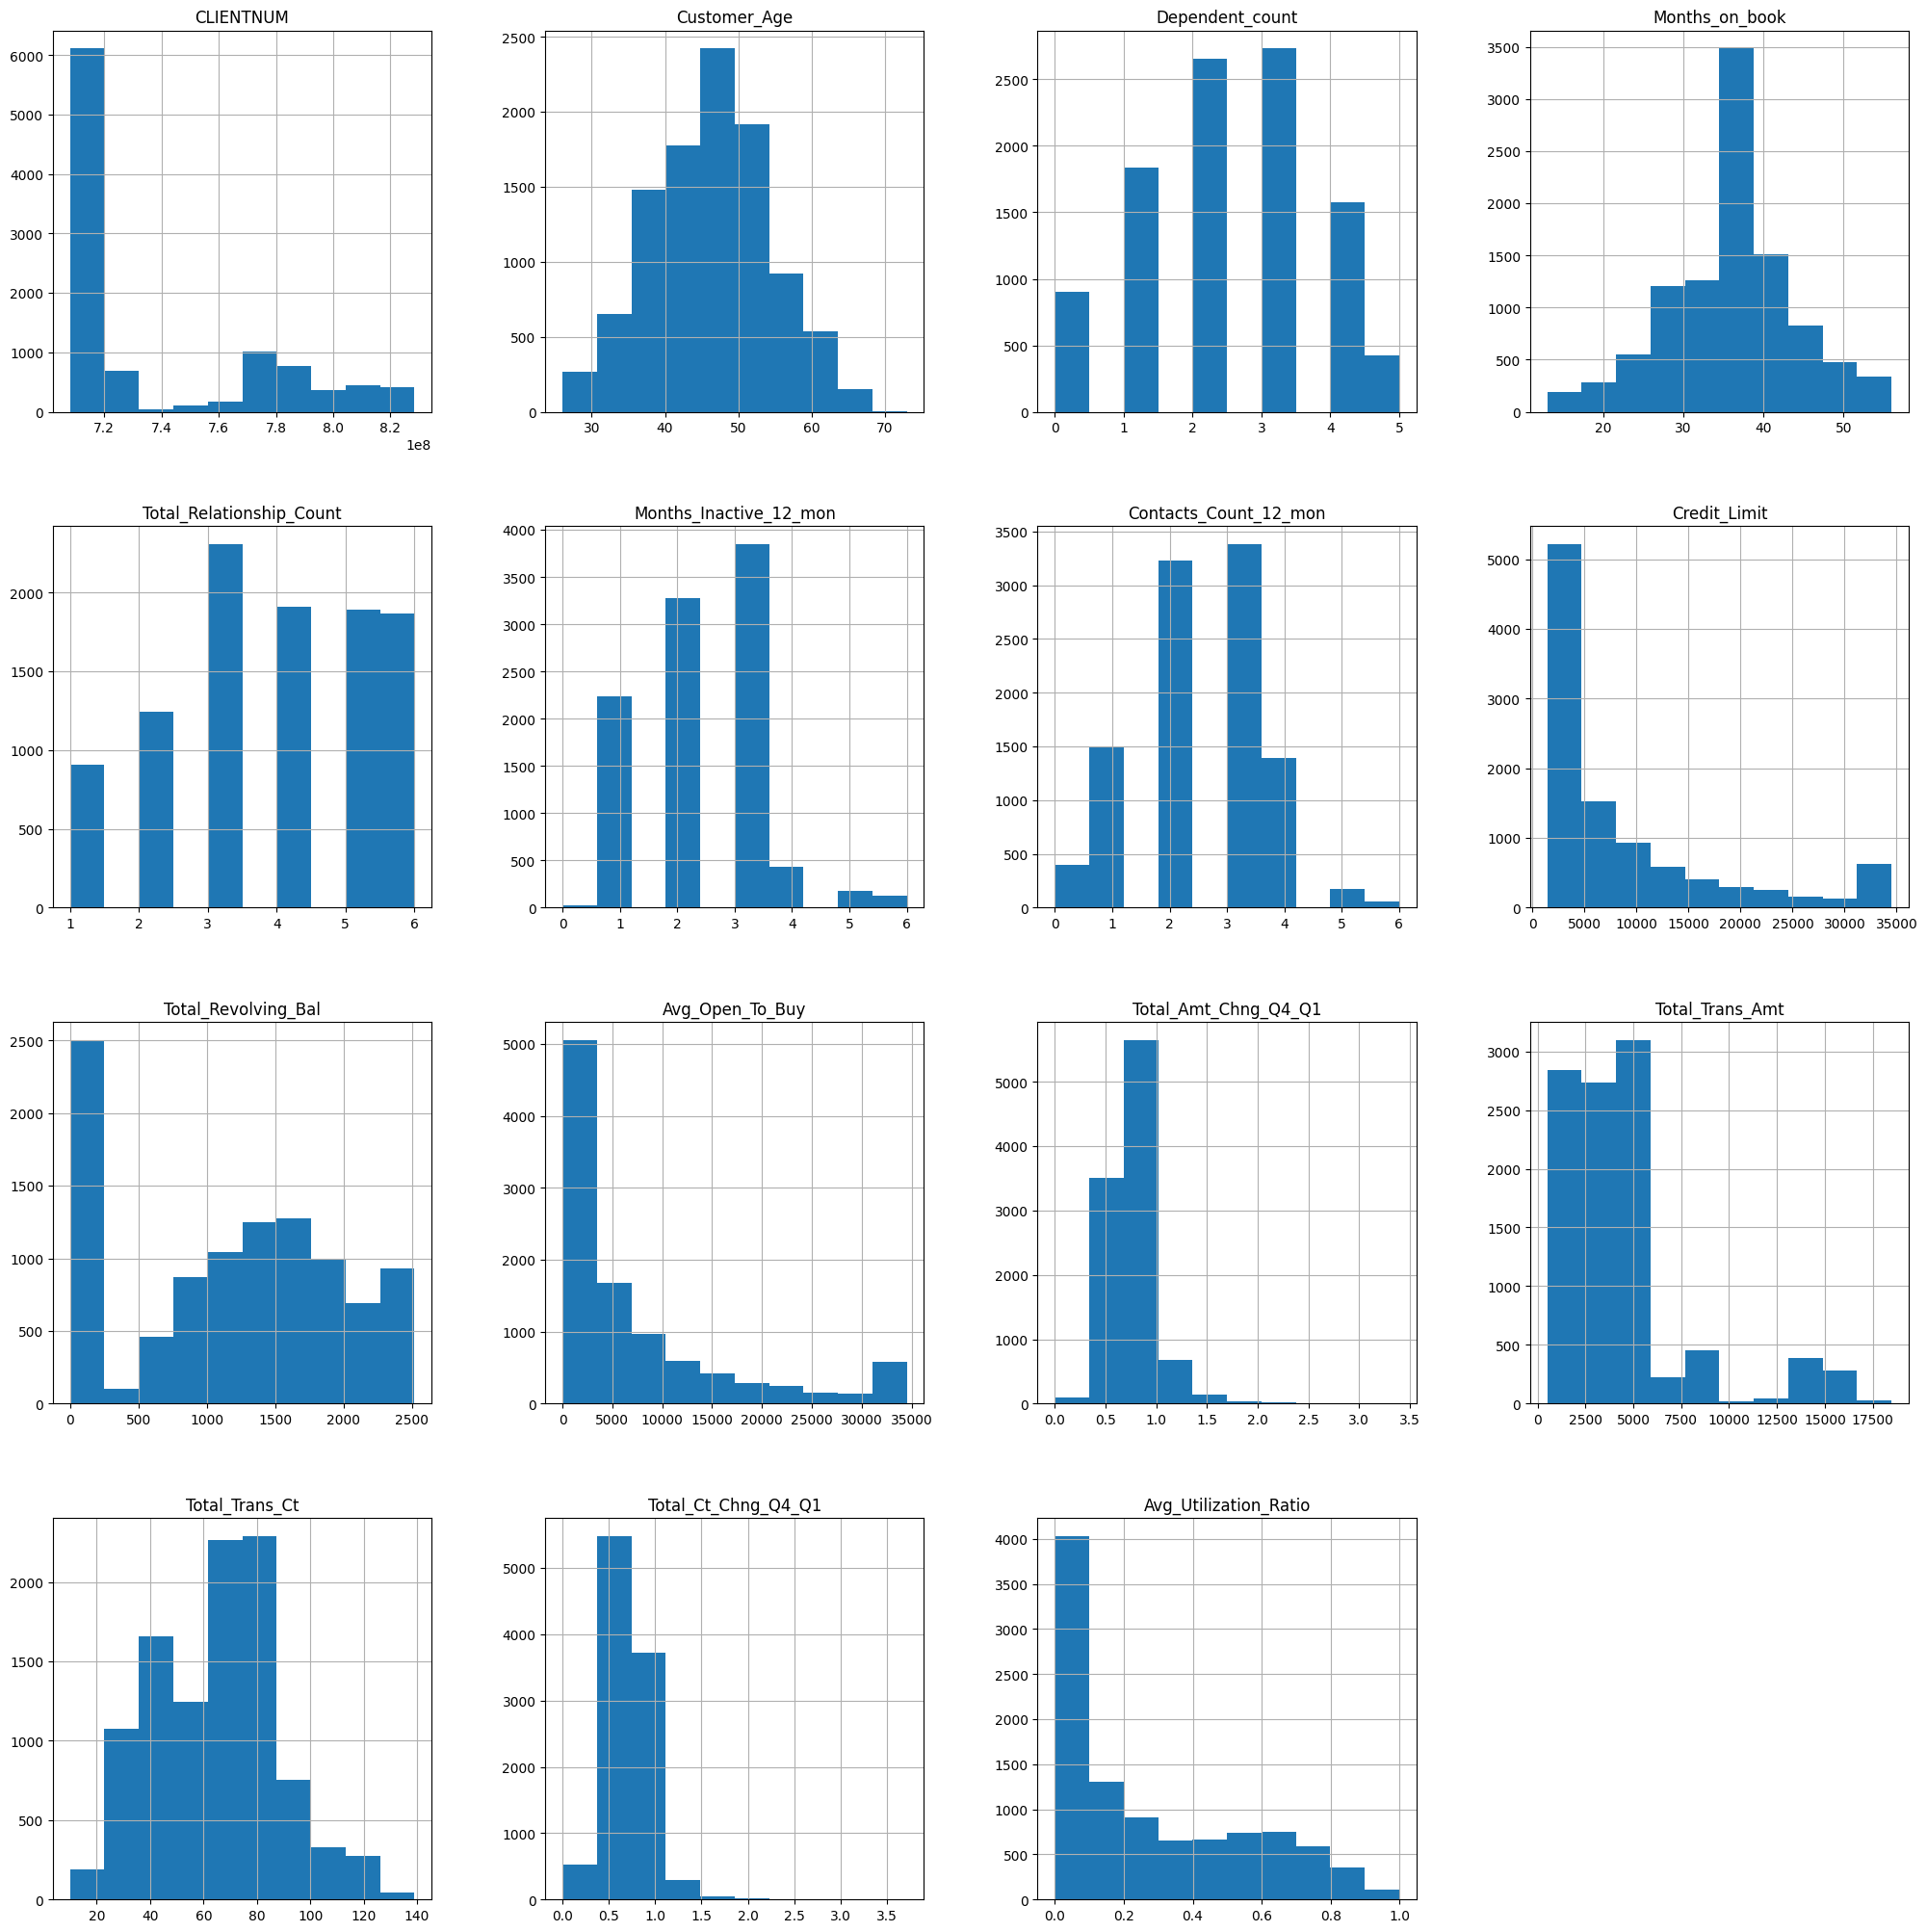

In [134]:
# Plot for Numerical Data

fig = plt.figure(figsize = (20,20))
ax = fig.gca()
plt.tight_layout()
df.loc[:, ~df_main.columns.isin(['CLIENTNUM', "Attrition_Flag_Int"])].hist(ax = ax)
fig.show()

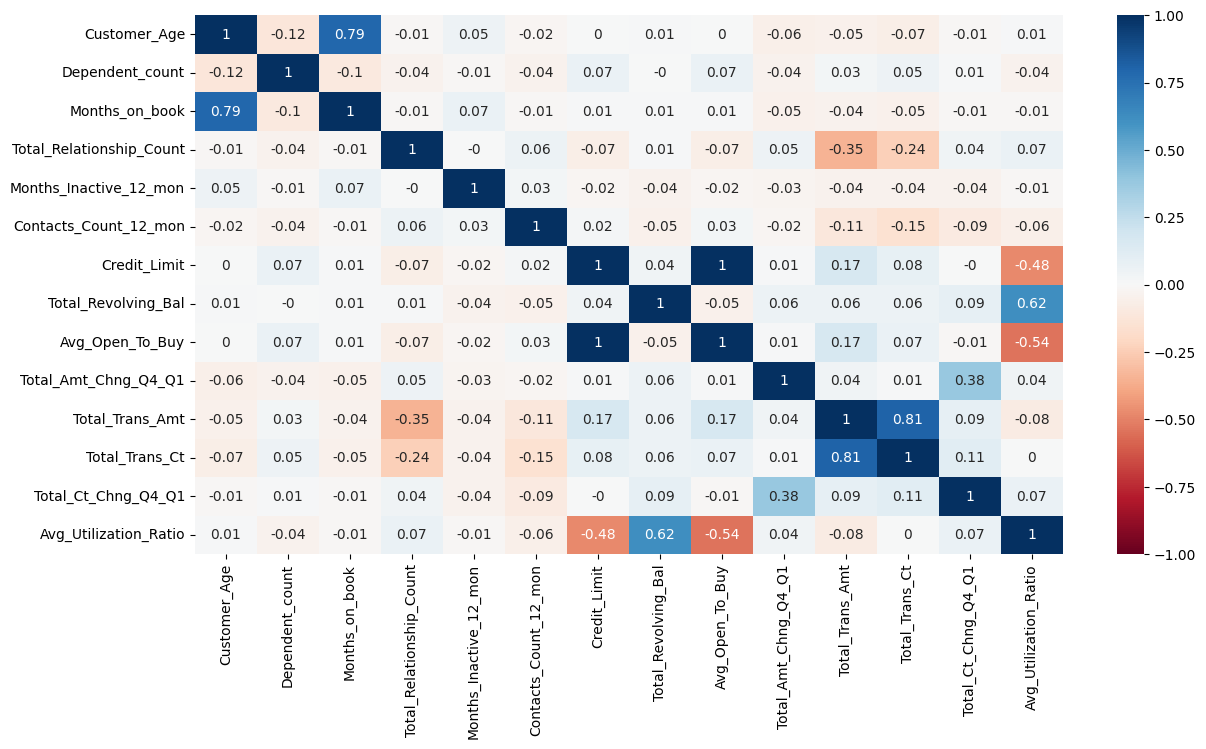

In [15]:
correlation = df.loc[:, ~df.columns.isin(['CLIENTNUM'])].corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'RdBu', vmin=-1, vmax=1)
plt.show()


### Observing the heatmap above, we can state the following.
- #### Total_Revolving_bal and Avg_Utilization_Ratio are possitively correlated
- #### Avg_Utilization_Ratio and Avg_Open_To_Buy are negatively correlated


In [16]:
# Counting the Attrition Flags
# Attrited Customer = 0, Existing Customer = 1.

aggregate_data = df_main.groupby(['Attrition_Flag'])['CLIENTNUM'].count().to_frame().reset_index()
aggregate_data

,Attrition_Flag,CLIENTNUM
0,0,1627
1,1,8500


[Text(0, 0, '8500'), Text(0, 0, '1627')]

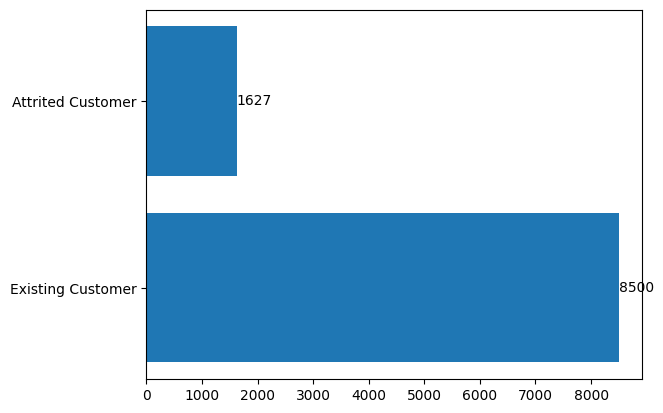

In [17]:


x = ['Existing Customer','Attrited Customer']
y = [df['Attrition_Flag'].value_counts()[0],df['Attrition_Flag'].value_counts()[1]]
fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)


In [19]:
# Put all the columns except Attrition_Flag in X_data and only the Attrition_Flag in y_data

X_data = df_main[[i for i in df_main.columns if i != "Attrition_Flag"]]
y_data = df_main["Attrition_Flag"]

In [20]:
params = {
    "max_depth": range(1, 9),
    "min_samples_split": [5, 7, 9, 12, 15],
    "min_samples_leaf": [5, 7, 9, 10, 12]
}

s_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

estimator = RandomForestClassifier(random_state=42)
scoring = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=estimator, 
    param_grid=params, 
    scoring=scoring, 
    cv=s_kfold, 
    n_jobs=-1
)

search_results = grid_search.fit(X_data, y_data)

best_params = search_results.best_params_
best_score = search_results.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15}
Best score: 0.9672994684011581


In [21]:
search_results.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15}

In [22]:
fi = pd.Series(search_results.best_estimator_.feature_importances_, index = X_data.columns)
fi

Gender                      0.007973
Education_Level             0.001810
Marital_Status              0.002889
Income_Category             0.004264
Card_Category               0.000735
CLIENTNUM                   0.007766
Customer_Age                0.018100
Dependent_count             0.003545
Months_on_book              0.010033
Total_Relationship_Count    0.079702
Months_Inactive_12_mon      0.021845
Contacts_Count_12_mon       0.017897
Credit_Limit                0.021925
Total_Revolving_Bal         0.130040
Avg_Open_To_Buy             0.018592
Total_Amt_Chng_Q4_Q1        0.049282
Total_Trans_Amt             0.215404
Total_Trans_Ct              0.191910
Total_Ct_Chng_Q4_Q1         0.113417
Avg_Utilization_Ratio       0.082870
dtype: float64

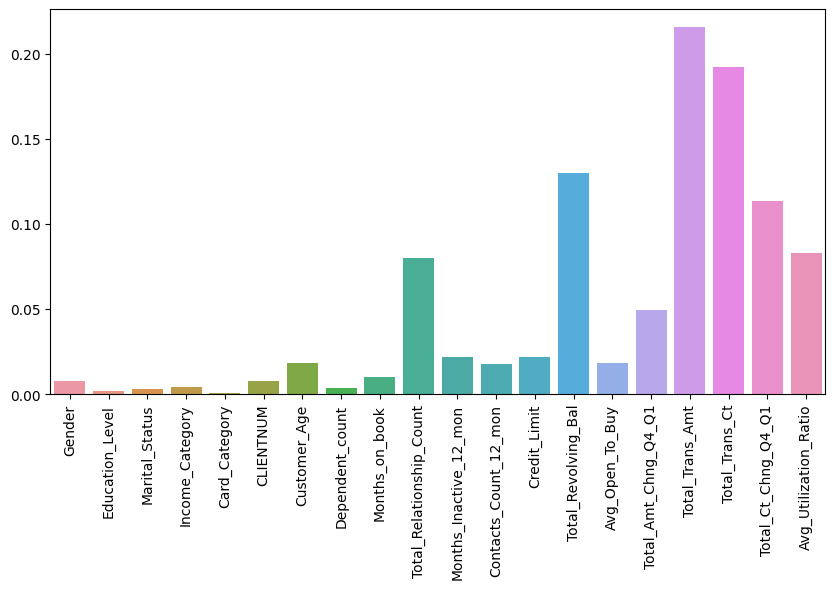

In [64]:
plt.figure(figsize=(10,5))
ax = plt.gca()

sns.barplot(x=fi.index, y=fi, ax=ax)
ax.tick_params(rotation=90, axis='x');


#### Thus we can say that the most important features to classify attrition are as follows - 
- ***Total_Relationship_Count***
- ***Total_Revolving_Bal***
- ***Total_Amt_Chng_Q4_Q1***
- ***Total_Trans_Amt***
- ***Total_Trans_Ct***
- ***Total_Ct_Chng_Q4_Q1***
- ***Avg_Utilization_Ratio***



In [23]:
important_features = fi[fi >= 0.04].index.to_list()
important_features

['Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [24]:
reduced_data = df_main.loc[:,['Total_Revolving_Bal',
 'Total_Relationship_Count',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
'Attrition_Flag']]

df_reduced = reduced_data.copy()

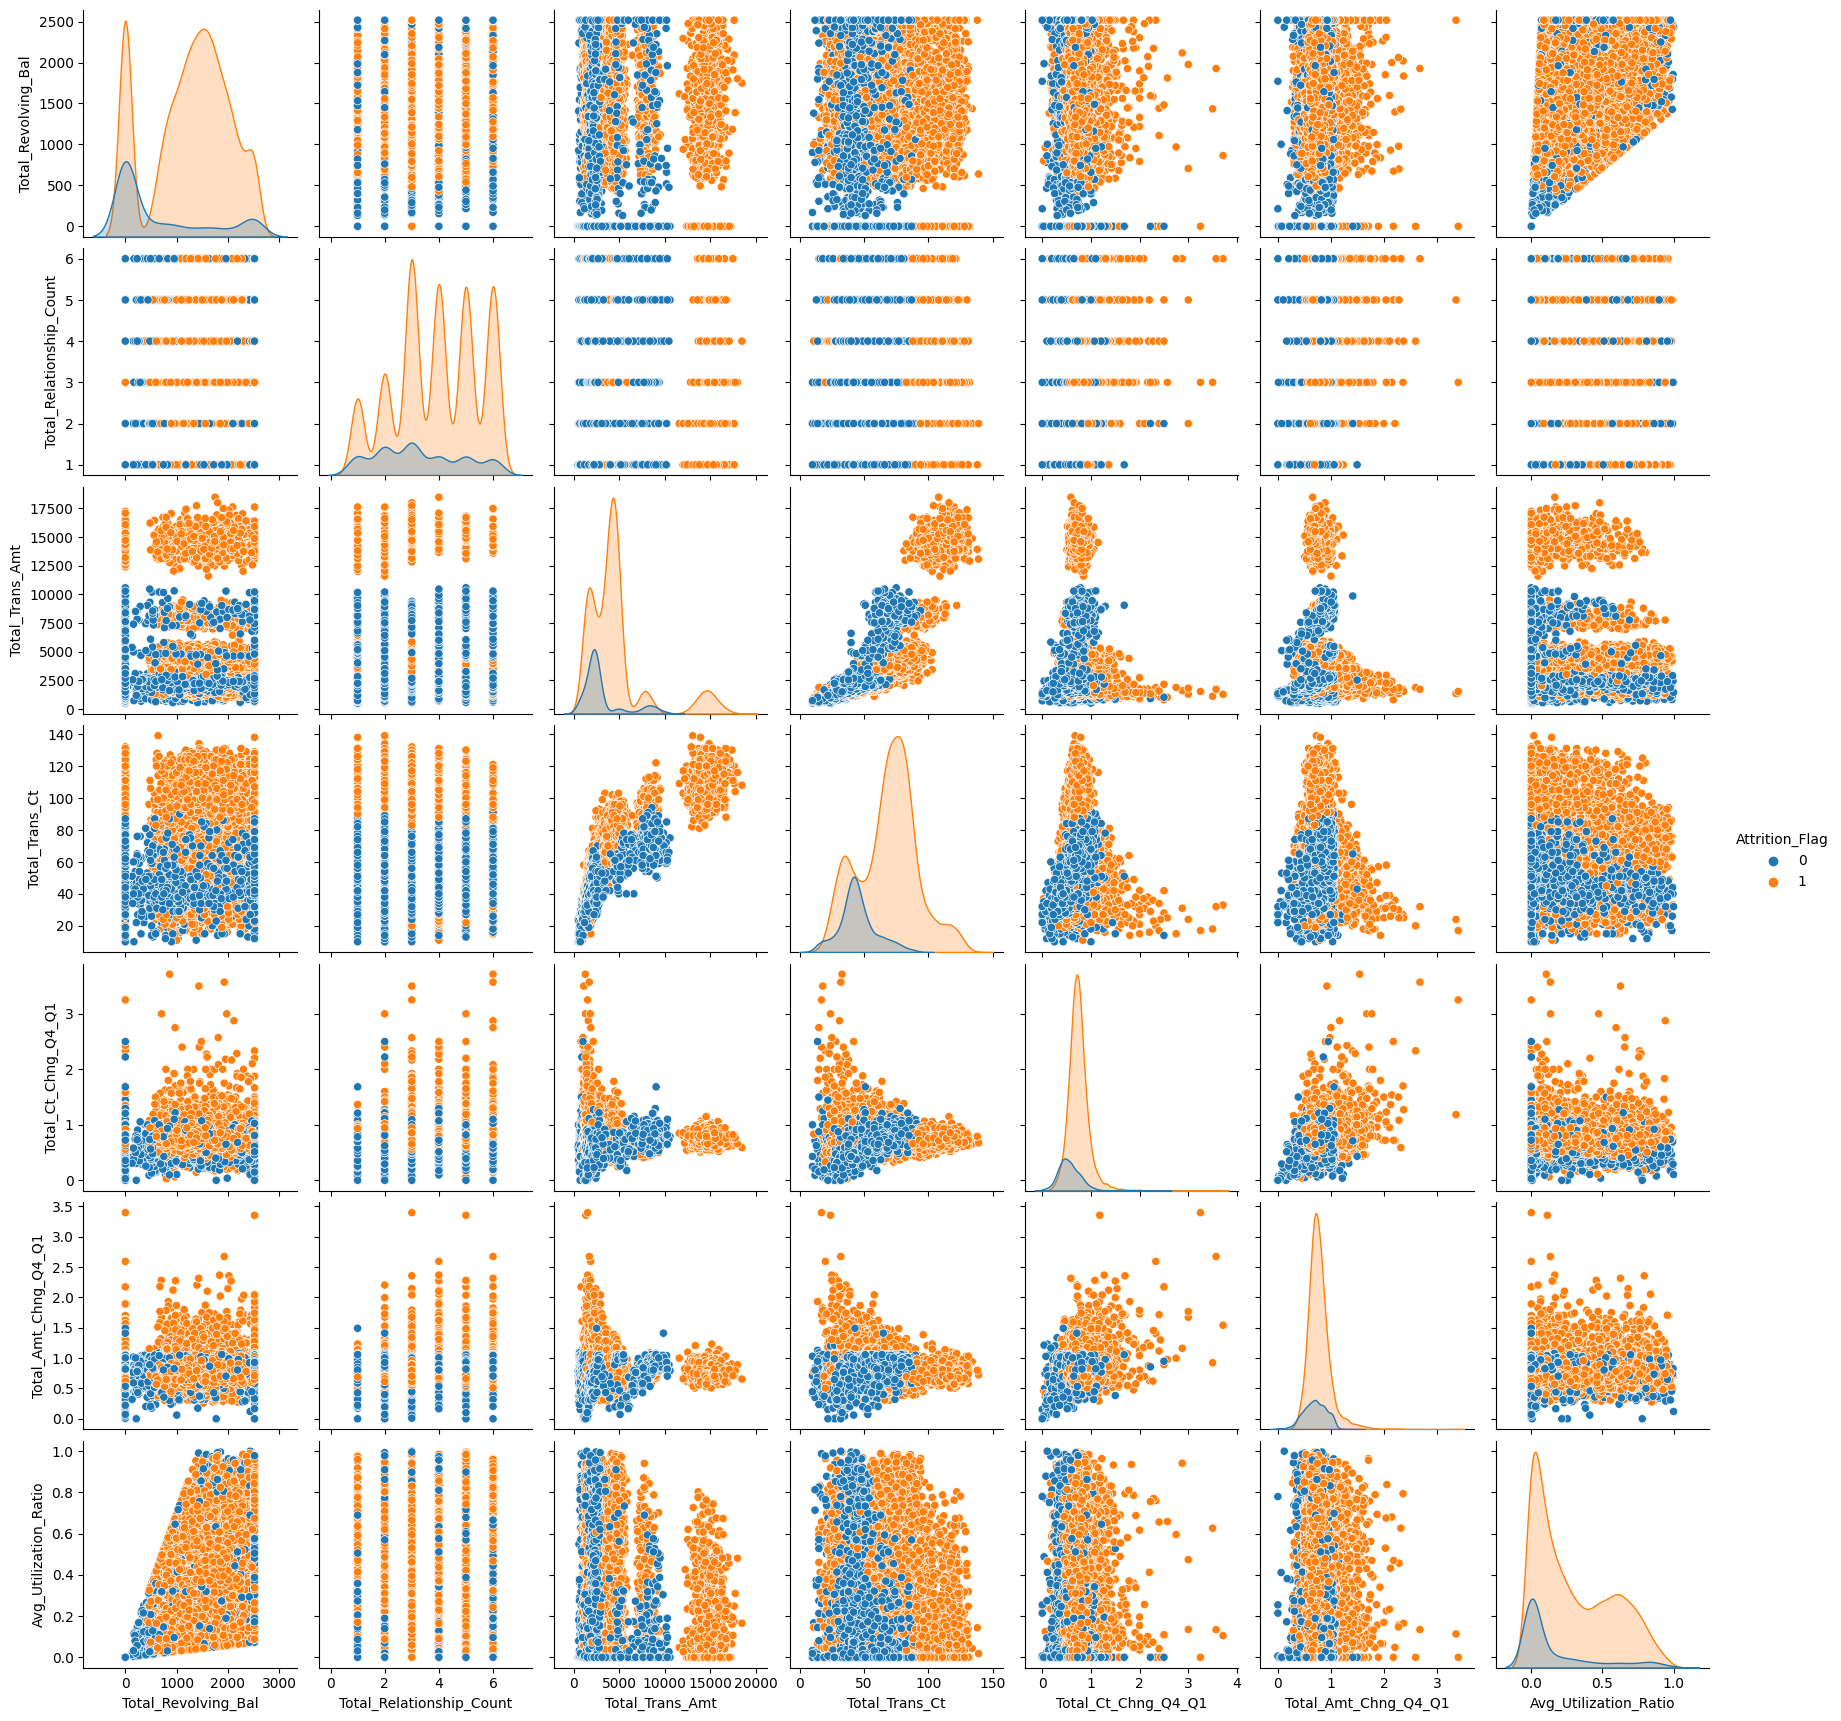

In [25]:
sns.pairplot(reduced_data, hue='Attrition_Flag', diag_kind='kde');

In [26]:
std_scaler = StandardScaler()
reduced_data = std_scaler.fit_transform(reduced_data)

std_scaler2 = StandardScaler()
full_data = std_scaler2.fit_transform(df_main)

## CLustering for KMeans

In [27]:
lis_main = []
sil_score_main = []
for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(full_data)
    predict = model.fit_predict(full_data)

    lis_main.append(model.inertia_)
    sil_score_main.append(silhouette_score(full_data,predict))

In [28]:
lis = []
sil_score_reduced = []
for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(reduced_data)
    predict = model.fit_predict(reduced_data)

    lis.append(model.inertia_)
    sil_score_reduced.append(silhouette_score(reduced_data,predict))

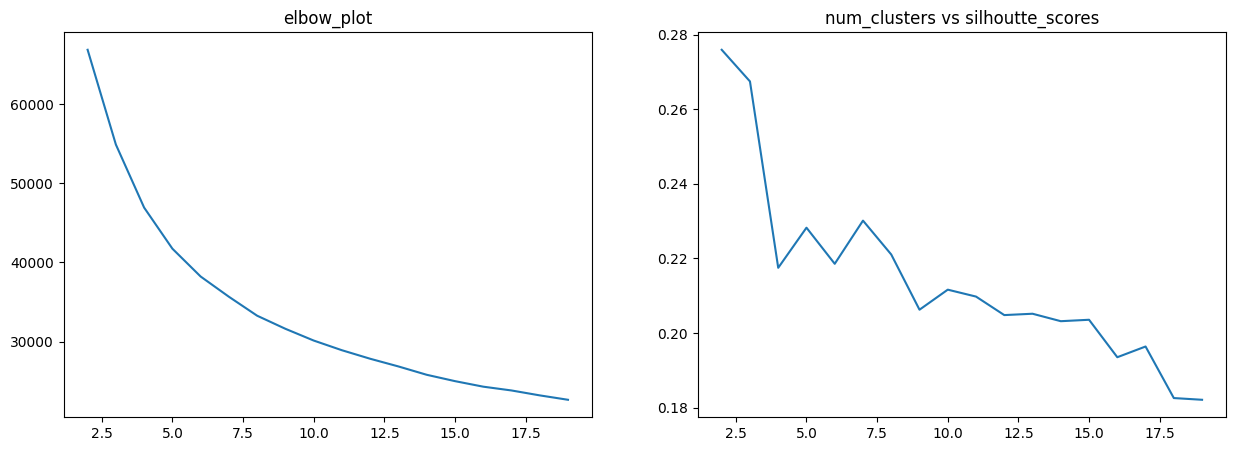

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x=range(2,20), y=lis, ax=ax[0])
ax[0].set_title("elbow_plot");

sns.lineplot(x=range(2,20), y=sil_score_reduced, ax=ax[1])
ax[1].set_title("num_clusters vs silhoutte_scores");

silhoutte score at K = 6. This is the best one we could get.
We see elbow at 6 so it is the best value as per the observation 

In [53]:
kmeans_model = KMeans(n_clusters=6, random_state=42)
kmeans_model.fit(reduced_data)
kmeans_prediction = kmeans_model.fit_predict(reduced_data)

silhouette_score(reduced_data,kmeans_prediction)

0.2185546719412025

In [54]:
# inverse transform and assign to kmeans_predicted
kmeans_predicted = pd.DataFrame(Total_Revolving_Bal)
kmeans_predicted["pred_clusters"] = kmeans_prediction


In [55]:
kmeans_predicted.groupby("pred_clusters").count().iloc[:, 1]


pred_clusters
0    2334
1    1883
2    2498
3    1494
4    1124
5     794
Name: 1, dtype: int64

In [56]:
print(kmeans_predicted.columns)


Index([0, 1, 2, 3, 4, 5, 6, 7, 'pred_clusters'], dtype='object')


In [51]:
kmeans_predicted.head()

,0,1,2,3,4,5,6,7,pred_clusters
0,777.0,5.0,1144.0,42.0,1.625,1.335,0.061,1.0,5
1,864.0,6.0,1291.0,33.0,3.714,1.541,0.105,1.0,5
2,0.0,4.0,1887.0,20.0,2.333,2.594,0.000,1.0,5
3,2517.0,3.0,1171.0,20.0,2.333,1.405,0.760,1.0,5
4,0.0,5.0,816.0,28.0,2.500,2.175,0.000,1.0,5


In [68]:
kmeans_predicted.rename(columns = {0:'Total_revolving_Bal'}, inplace = True)
kmeans_predicted.rename(columns={1:'Total_Relationship_Count'}, inplace=True)
kmeans_predicted.rename(columns = {2:'Total_Trans_Amt'}, inplace = True)
kmeans_predicted.rename(columns = {3:'Total_Trans_Ct'}, inplace = True)
kmeans_predicted.rename(columns = {4:'Total_Ct_Chng_Q4_Q1'}, inplace = True)
kmeans_predicted.rename(columns = {5:'Total_Amt_Chng_Q4_Q1'}, inplace = True)
kmeans_predicted.rename(columns = {6:'Avg_Utilization_Ratio'}, inplace = True)
kmeans_predicted.rename(columns = {7:'Attrition_Flag'}, inplace = True)

In [69]:
kmeans_predicted.head()

,Total_revolving_Bal,Total_Relationship_Count,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Total_Amt_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,pred_clusters
0,777.0,5.0,1144.0,42.0,1.625,1.335,0.061,1.0,5
1,864.0,6.0,1291.0,33.0,3.714,1.541,0.105,1.0,5
2,0.0,4.0,1887.0,20.0,2.333,2.594,0.000,1.0,5
3,2517.0,3.0,1171.0,20.0,2.333,1.405,0.760,1.0,5
4,0.0,5.0,816.0,28.0,2.500,2.175,0.000,1.0,5


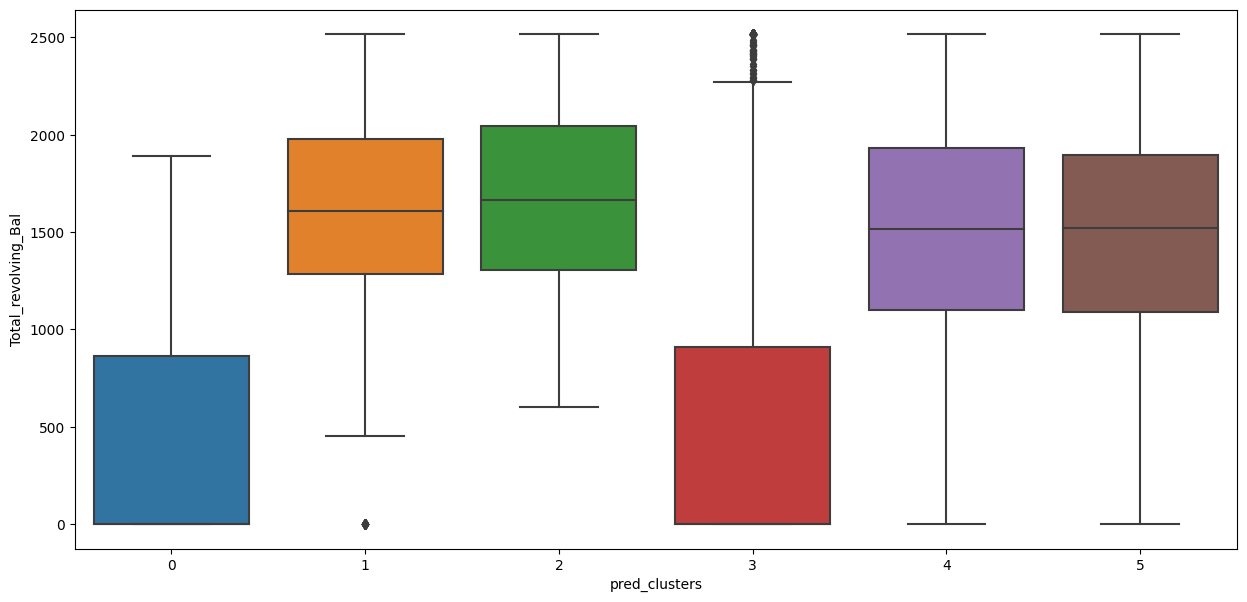

In [70]:
plt.figure(figsize=(15,7))
sns.boxplot(y=kmeans_predicted['Total_revolving_Bal'], x=kmeans_predicted["pred_clusters"]);

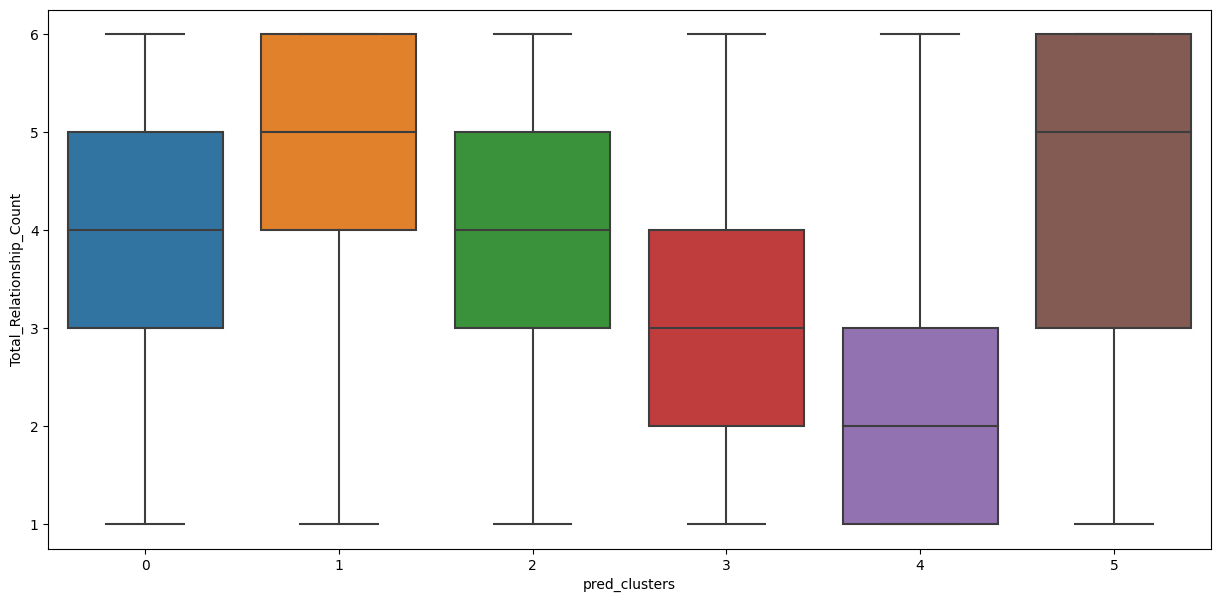

In [71]:
plt.figure(figsize=(15,7))
sns.boxplot(y=kmeans_predicted["Total_Relationship_Count"], x=kmeans_predicted["pred_clusters"]);

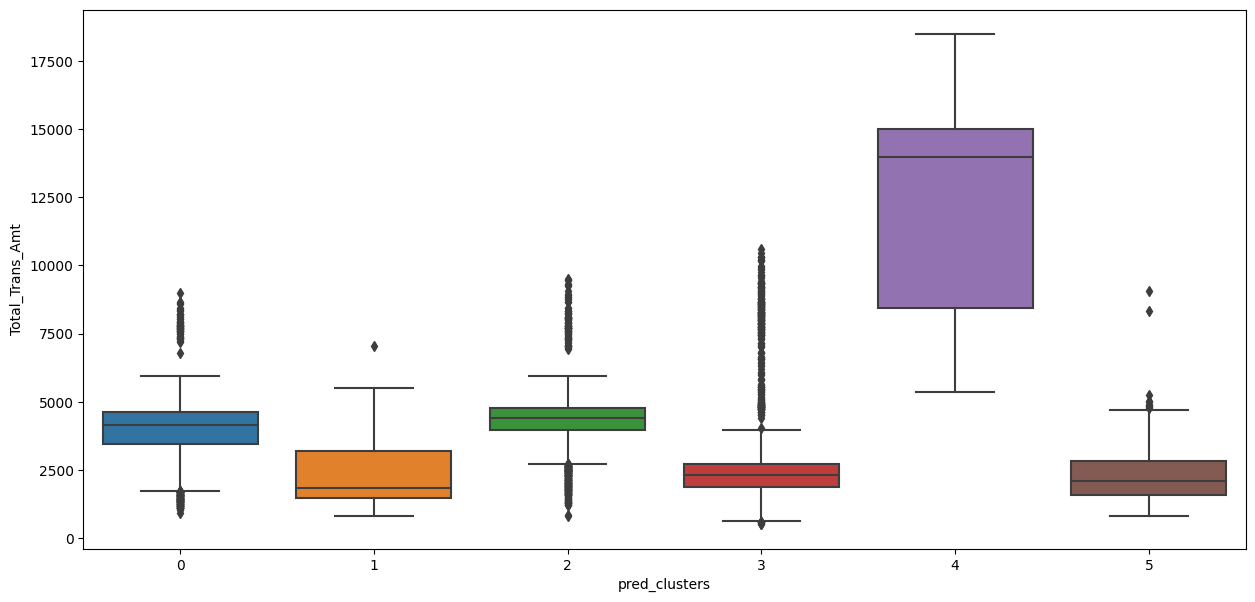

In [72]:
plt.figure(figsize=(15,7))
sns.boxplot(y=kmeans_predicted["Total_Trans_Amt"], x=kmeans_predicted["pred_clusters"]);

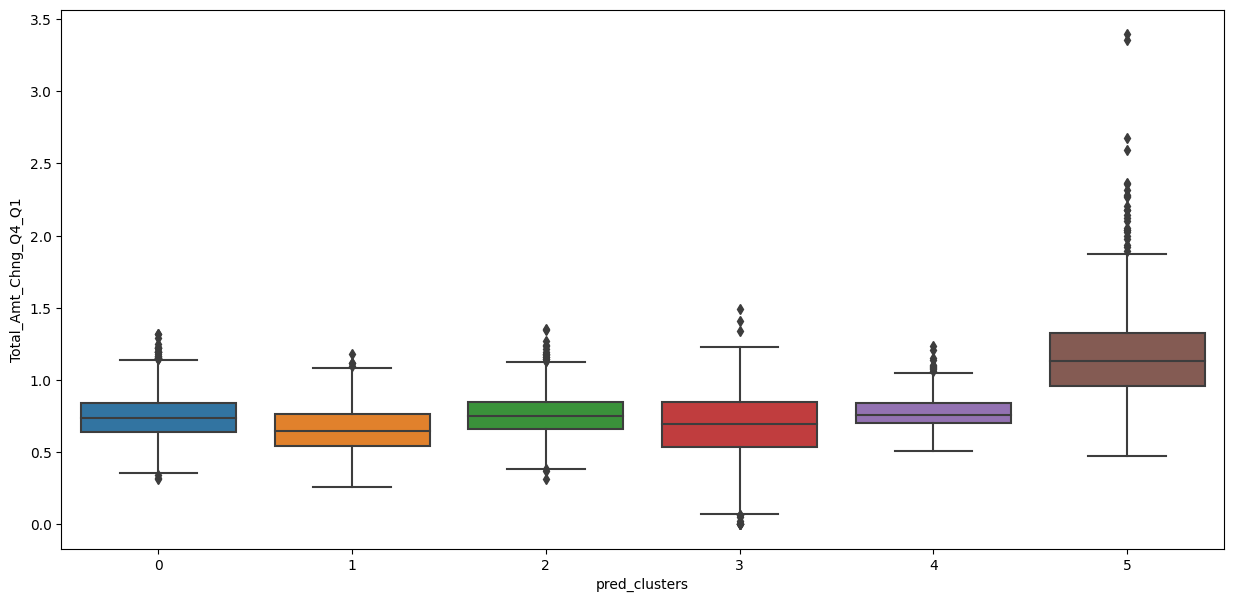

In [73]:
plt.figure(figsize=(15,7))
sns.boxplot(y=kmeans_predicted["Total_Amt_Chng_Q4_Q1"], x=kmeans_predicted["pred_clusters"]);

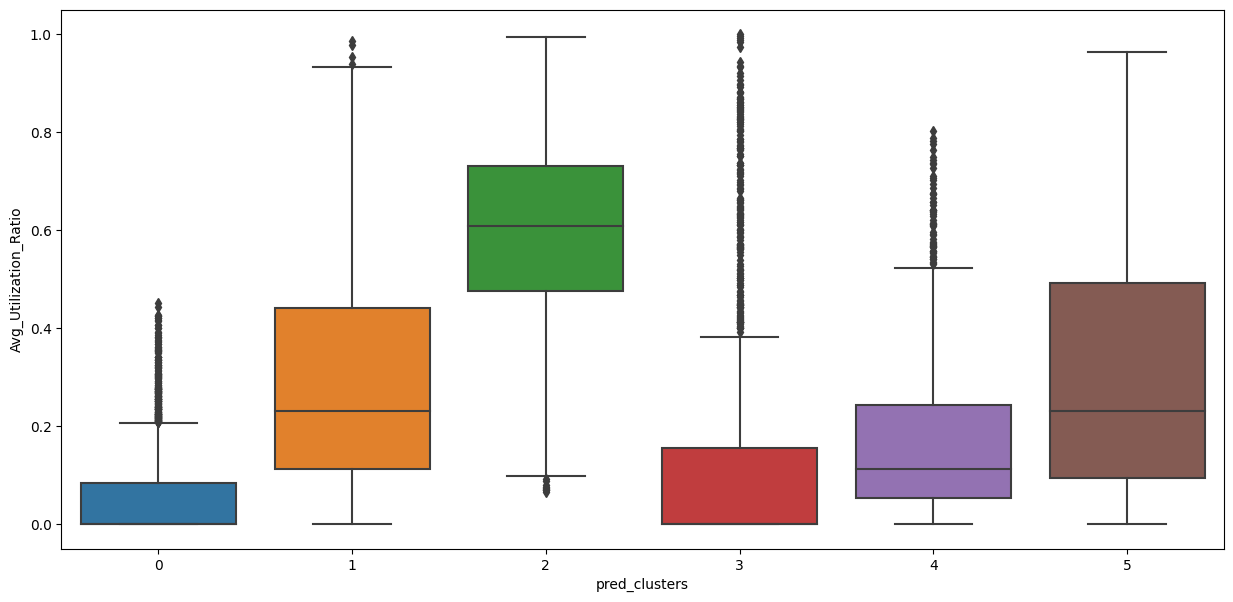

In [74]:
plt.figure(figsize=(15,7))
sns.boxplot(y=kmeans_predicted['Avg_Utilization_Ratio'], x=kmeans_predicted["pred_clusters"]);

- ***Visually at least, there appears to be a very small amount overlap of clusters***
- ***This means the clusters are essentially different and thus we can differentiate the custeomers based on the attrition***
- ***silhoutte score obtained is not good as the range lies between 1 and -1, and we see the score to be arount 0.21 which is decent but makes it clear the KMeans is not one of the better option.***

##### **The silhoutte score is quite low so it does not seem to be a good method for this data set as the silhouette score defines how close are the data points to the said clusters and can help determine if the classification is valid. Due to this, we can not rely on this method due to the ambiguity being present in the data set and thus resulting in a low score.**

## Applying KNN



In [35]:
df_reduced.head(20)

,Total_Revolving_Bal,Total_Relationship_Count,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Total_Amt_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,777,5,1144,42,1.625,1.335,0.061,1
1,864,6,1291,33,3.714,1.541,0.105,1
2,0,4,1887,20,2.333,2.594,0.000,1
3,2517,3,1171,20,2.333,1.405,0.760,1
4,0,5,816,28,2.500,2.175,0.000,1
5,1247,3,1088,24,0.846,1.376,0.311,1
6,2264,6,1330,31,0.722,1.975,0.066,1
7,1396,2,1538,36,0.714,2.204,0.048,1
8,2517,5,1350,24,1.182,3.355,0.113,1
9,1677,6,1441,32,0.882,1.524,0.144,1


In [36]:
x = df_reduced.drop(columns=['Attrition_Flag'])
y = df_reduced['Attrition_Flag']
x.shape, y.shape

((10127, 7), (10127,))

In [37]:
x.head(20)

,Total_Revolving_Bal,Total_Relationship_Count,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Total_Amt_Chng_Q4_Q1,Avg_Utilization_Ratio
0,777,5,1144,42,1.625,1.335,0.061
1,864,6,1291,33,3.714,1.541,0.105
2,0,4,1887,20,2.333,2.594,0.000
3,2517,3,1171,20,2.333,1.405,0.760
4,0,5,816,28,2.500,2.175,0.000
5,1247,3,1088,24,0.846,1.376,0.311
6,2264,6,1330,31,0.722,1.975,0.066
7,1396,2,1538,36,0.714,2.204,0.048
8,2517,5,1350,24,1.182,3.355,0.113
9,1677,6,1441,32,0.882,1.524,0.144


In [38]:
# StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance

X = StandardScaler().fit_transform(x)
X[:3]

array([[-0.47342222,  0.76394261, -0.95970657, -0.97389518,  3.8340026 ,
         2.62349444, -0.77588223],
       [-0.36666682,  1.40730617, -0.91643261, -1.35734038, 12.60857291,
         3.56329284, -0.61627565],
       [-1.42685834,  0.12057905, -0.74098169, -1.91120566,  6.80786367,
         8.36721381, -0.99715499]])

In [39]:
# Creating Test and Train split for KNN.

x_train, x_test, y_train, y_test = train_test_split(X,y,stratify=y)


In [40]:
# Fucntion to check for different K - Nearest neighbors

def knn_scores(X, y, start, stop, step):
    list_scores = []
    for i in range(start,stop,step):
        model = KNeighborsClassifier(n_neighbors=i)
        kfold = KFold(n_splits=10, shuffle=True, random_state=44)
        cross_val_scores_KNN = cross_val_score(model, X,y,cv=kfold)
        dict_row_score = {'mean_score': np.mean(cross_val_scores_KNN), 'std_score': np.std(cross_val_scores_KNN), 'n_neighbours' :i}
        list_scores.append(dict_row_score)

    df_knn_scores = pd.DataFrame(list_scores)

    df_knn_scores['Lower_Bound'] = df_knn_scores['mean_score'] - df_knn_scores['std_score']
    df_knn_scores['Upper_Bound'] = df_knn_scores['mean_score'] + df_knn_scores['std_score']

    return df_knn_scores


In [41]:
# Try 1 to 20 neigbours
df_knn_scores = knn_scores(x_train, y_train, 1, 21, 1)

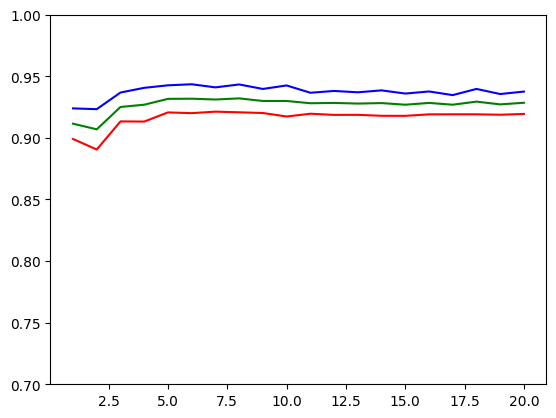

In [42]:
# Plotting best scorses.

plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['Lower_Bound'], color ='r')
plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['mean_score'], color ='g')
plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['Upper_Bound'], color ='b')
plt.ylim(0.7,1);

In [43]:
# Check the hyperparameter with the higher score
df_knn_scores.loc[df_knn_scores.mean_score == df_knn_scores.mean_score.max()]

,mean_score,std_score,n_neighbours,Lower_Bound,Upper_Bound
7,0.932061,0.011302,8,0.920758,0.943363


In [44]:
best_k = df_knn_scores.loc[df_knn_scores.mean_score == df_knn_scores.mean_score.max(), 'n_neighbours'].values[0]
print('The best K is ' + str(best_k)) 
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train, y_train)

The best K is 8


KNeighborsClassifier(n_neighbors=8)

In [45]:
# Applying the model

y_knn_predict = model.predict(x_test)

In [46]:
# Calculating the Specificity score. 

confusion_knn=confusion_matrix(y_test, y_knn_predict)
TP = confusion_knn[1, 1]
TN = confusion_knn[0, 0]
FP = confusion_knn[0, 1]
FN = confusion_knn[1, 0]

specificity_knn = TN / (TN + FP)
print('The Specificity Score is ' + str(specificity_knn))

The Specificity Score is 0.769041769041769


In [47]:
# Accuracy, Precision, Recall, F1 score

df_KNN = pd.DataFrame(classification_report(y_knn_predict,y_test, digits=2,output_dict=True)).T

df_KNN['support'] = df_KNN.support.apply(int)

df_KNN.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.769042,0.823684,0.795426,380
1,0.968471,0.956320,0.962357,2152
accuracy,0.936414,0.936414,0.936414,0
macro avg,0.868756,0.890002,0.878891,2532
weighted avg,0.938541,0.936414,0.937304,2532


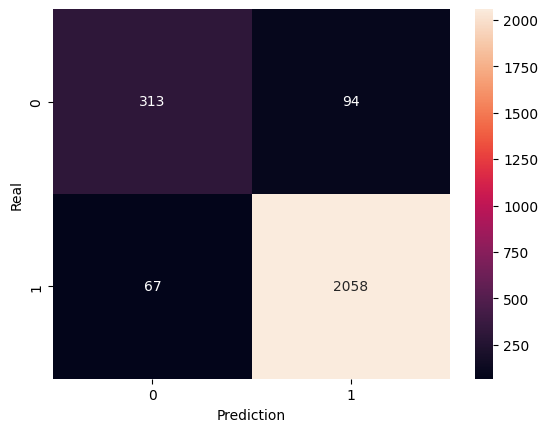

In [48]:
# Heat Map for KNN

sns.heatmap(confusion_matrix(y_test, y_knn_predict), annot=True, fmt='.0f')
plt.ylabel('Real')
plt.xlabel('Prediction');

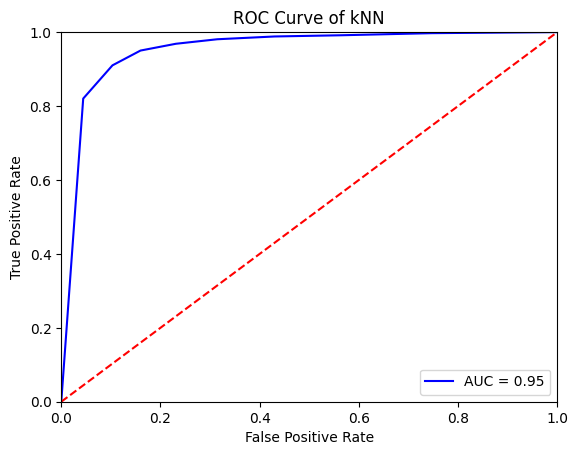

In [49]:
# ROC Curve of KNN

y_scores = model.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### Logistic Regression

In [76]:
# Creating test and train splits for Logistic Regression.

x_train, x_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state =44 )
lr = LogisticRegression(penalty=None)
lr.fit(x_train, y_train); 
y_predict_lr = lr.predict(x_test)
y_lr_pred_prob = lr.predict_proba(x_test)
print(y_predict_lr)
print('\n')
print(y_lr_pred_prob)

[1 1 1 ... 1 1 1]


[[0.01166497 0.98833503]
 [0.00961253 0.99038747]
 [0.08751191 0.91248809]
 ...
 [0.25987518 0.74012482]
 [0.05248239 0.94751761]
 [0.00899795 0.99100205]]


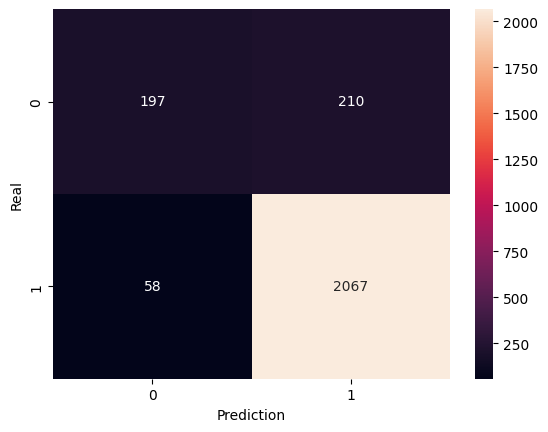

In [78]:
# Heat Map

sns.heatmap(confusion_matrix(y_test, y_predict_lr), annot=True, fmt='.0f')
plt.ylabel('Real')
plt.xlabel('Prediction');


In [79]:
# Accuracy, Precision, Recall, F1 score

df_logR = pd.DataFrame(classification_report(y_predict_lr,y_test, digits=2,output_dict=True)).T

df_logR['support'] = df_logR.support.apply(int)

df_logR.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.484029,0.772549,0.595166,255
1,0.972706,0.907773,0.939119,2277
accuracy,0.894155,0.894155,0.894155,0
macro avg,0.728368,0.840161,0.767142,2532
weighted avg,0.923491,0.894155,0.904479,2532


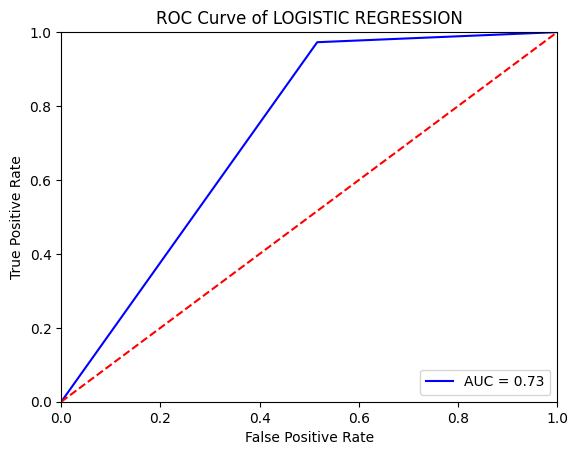

In [80]:
# ROC Curve of Logistic Regression

Y_scores = lr.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_predict_lr)
roc_auc = auc(fpr, tpr)

plt.title('Logistic RegressionClassifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LOGISTIC REGRESSION')
plt.show()

## Conclusion


### 1. Given the fact that we are trying to identify clients with a possible attrition, our lead metric should be the Recall Sensitivity of the model (If we are going to personalize a retention campaign, the false positives shouldn't be be a problem as long as I don't miss the true positives).


### 2. In this case I would choose the KNN model to identify the users with a possible attrition.